
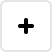
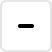
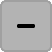
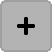
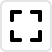
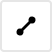
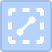
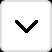
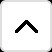
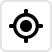

In [1]:
import numpy as np
import pandas as pd

from lets_plot import *
LetsPlot.setup_html()

In [2]:
_CARDINALITY_THRESHOLD = 15
_COLOR_DEF = "#118ED8"

class pair_plot:

    def __init__(self, data, *, columns=None, cardinality_threshold=None, color=None, color_by=None, width=1000, height=1000):
        self._init_data(data, columns)
        self._cardinality_threshold = cardinality_threshold or _CARDINALITY_THRESHOLD
        self._color = color or _COLOR_DEF
        self._color_by = color_by
        self._width = width
        self._height = height
        self._settings = {
            'diag': {
                'continuous': geom_histogram(),
                'discrete': geom_bar(),
            },
            'upper': {
                'continuous': {
                    'continuous': geom_point(),
                    'discrete': geom_boxplot(),
                },
                'discrete': {
                    'continuous': geom_boxplot(),
                    'discrete': geom_bin2d(),
                },
            },
            'lower': {
                'continuous': {
                    'continuous': geom_point(),
                    'discrete': geom_boxplot(),
                },
                'discrete': {
                    'continuous': geom_boxplot(),
                    'discrete': geom_point(),
                },
            },
        }

    def cross(self, type=None, *, var_type=None, row_var_type=None, col_var_type=None, geom=None):
        if type == 'diag':
            self._settings['diag'][var_type] = geom
        elif type == 'upper':
            self._settings['upper'][row_var_type][col_var_type] = geom
        elif type == 'lower':
            self._settings['lower'][row_var_type][col_var_type] = geom
        else:
            raise Exception("Wrong cross type: {0}".format(type))
        return self

    def build(self):
        w, h = int(self._width / len(self._columns)), int(self._height / len(self._columns))
        bunch = GGBunch()
        for i, row_name in enumerate(self._columns):
            for j, col_name in enumerate(self._columns):
                p = None
                if i == j:
                    var_type = 'discrete' if self._df[row_name].dtype == 'O' else 'continuous'
                    p = ggplot(self._df, aes(row_name)) + \
                        self._settings['diag'][var_type] + \
                        xlab(row_name) + ylab(row_name)
                elif i < j:
                    row_var_type = 'discrete' if self._df[row_name].dtype == 'O' else 'continuous'
                    col_var_type = 'discrete' if self._df[col_name].dtype == 'O' else 'continuous'
                    p = ggplot(self._df, aes(col_name, row_name)) + \
                        self._settings['upper'][row_var_type][col_var_type] + \
                        xlab(col_name) + ylab(row_name)
                else:
                    row_var_type = 'discrete' if self._df[row_name].dtype == 'O' else 'continuous'
                    col_var_type = 'discrete' if self._df[col_name].dtype == 'O' else 'continuous'
                    p = ggplot(self._df, aes(row_name, col_name)) + \
                        self._settings['lower'][row_var_type][col_var_type] + \
                        coord_flip() + \
                        xlab(row_name) + ylab(col_name)
                p += theme_minimal()
                bunch.add_plot(p, j * w, i * h, w, h)
        return bunch.show()

    def _init_data(self, data, columns):
        self._df = data.copy() if isinstance(data, pd.DataFrame) else pd.DataFrame(data)
        self._columns = columns or self._df.columns

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/JetBrains/lets-plot-docs/master/data/iris.csv")
print(df.shape)
df.head()

(150, 5)


sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [4]:
pair_plot(df)\
    .cross(type='upper', row_var_type='continuous', col_var_type='continuous', geom=geom_density2d())\
    .cross(type='upper', row_var_type='continuous', col_var_type='discrete', geom=geom_violin())\
    .build()